In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from spreg import OLS
from libpysal.weights import Kernel
from esda.moran import Moran
import statsmodels.api as sm
from scipy import stats

In [2]:
# Read in all the data

AQMS_df=pd.read_csv('data/hourly.csv')
Rd_gdf=gpd.read_file('data/london_Road.shp')
Gsp_gdf=gpd.read_file('data/LD_GreenSpace.shp')
loc_gdf=gpd.read_file('data/AQMS_loc.shp')
cond=pd.read_csv('data/cond_hourly.csv')

In [3]:
# reindex loc_gdf and set buffer zones around each site (1km)

loc_gdf=loc_gdf.set_index('siteid')
loc_gdf['buffer_1km']=loc_gdf['geometry'].buffer(1000)
loc_gdf.head()

,sitename,geometry,buffer_1km
siteid,,,
BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17..."
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18..."
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18..."
CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18..."
CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18..."


In [4]:
# Get all green spaces
Gsp=Gsp_gdf['geometry'].unary_union

# Get all roads
Rd=Rd_gdf['geometry'].unary_union

In [5]:
# Set buffer zones for every road (50m)
Rd_gdf['buffer_50m']=Rd_gdf['geometry'].buffer(50)
# Get all road buffer zones
Rd_buffer=Rd_gdf['buffer_50m'].unary_union

In [6]:
# Get all near-road green spaces
nRd_Gsp=Gsp.intersection(Rd_buffer)

In [7]:
# store all buffer zones in a list
AQMS_shp=[]
for site in loc_gdf.index:
    AQMS_shp.append(loc_gdf.loc[site,'buffer_1km'])

In [8]:
# get all roads, green spaces and near-road green spaces in buffer zones around every sites
Rd_shp=[]
Gsp_shp=[]
nRd_Gsp_shp=[]
for poly in AQMS_shp:
    Rd_shp.append(poly.intersection(Rd))
    Gsp_shp.append(poly.intersection(Gsp))
    nRd_Gsp_shp.append(poly.intersection(nRd_Gsp))
print(len(Rd_shp),len(Gsp_shp),len(nRd_Gsp_shp))

21 21 21


In [9]:
# append them into the dataframe
loc_gdf['Road']=Rd_shp
loc_gdf['GreenSpace']=Gsp_shp
loc_gdf['NR_GreenSpace']=nRd_Gsp_shp

# and set their data types to geometry
loc_gdf=loc_gdf.set_geometry('Road').set_geometry('GreenSpace').set_geometry('NR_GreenSpace')

In [10]:
# london boundary read in
london=gpd.read_file('data/london_boundary.shp')

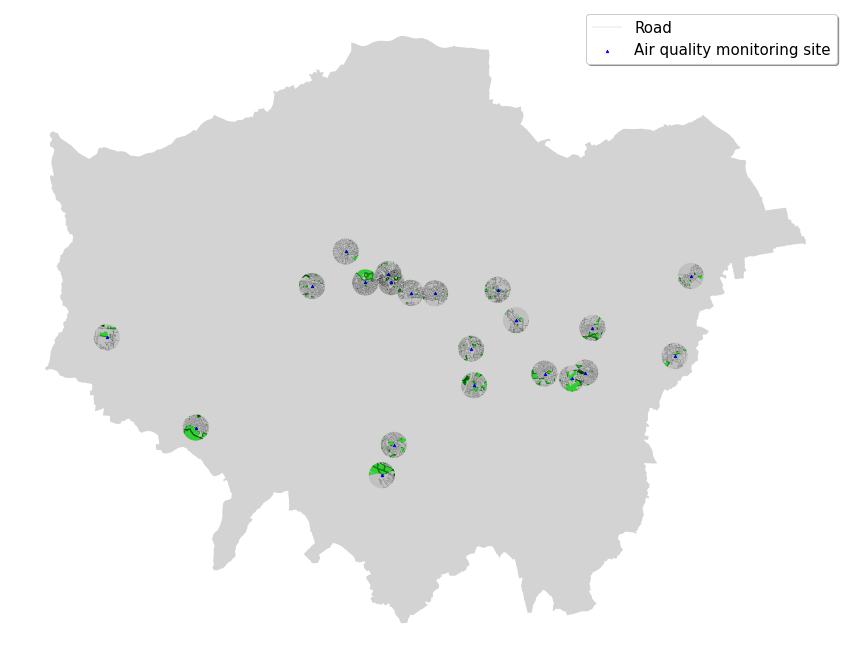

In [11]:
# visualise all the sites on the map
fig,ax=plt.subplots(1,figsize=(15,13))

london.plot(color='lightgrey',ax=ax)
loc_gdf['buffer_1km'].plot(color='silver',ax=ax)
loc_gdf['GreenSpace'].plot(label='Green space',color='limegreen',ax=ax)
loc_gdf['NR_GreenSpace'].plot(label='Near_road green space',color='darkgreen',ax=ax)
loc_gdf['Road'].plot(color='black',label='Road',linewidth=0.1,ax=ax)
loc_gdf['geometry'].plot(markersize=5,marker='^',color='blue',label='Air quality monitoring site',ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

There are some buffers that seem to be very close to each other.

In [12]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis']=pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis=[]
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index,'min_dis']=min(dis)

In [13]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis']<=1500]

,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace,min_dis
siteid,,,,,,,
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,"MULTIPOLYGON Z (((530885.507 181396.082 0.000,...","MULTIPOLYGON Z (((530885.507 181396.082 0.000,...",664.503439
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,...",664.503439
GR4,Greenwich - Eltham,POINT (543978.694 174655.234),"POLYGON ((544978.694 174655.234, 544973.878 17...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,"MULTIPOLYGON Z (((544534.534 173823.964 0.000,...","MULTIPOLYGON Z (((544534.534 173823.964 0.000,...",1111.316933
GB0,Greenwich - Falconwood FDMS,POINT (544997.933 175098.152),"POLYGON ((545997.933 175098.152, 545993.118 17...",MULTILINESTRING Z ((544952.089 174100.404 0.00...,"MULTIPOLYGON Z (((545373.964 174171.892 0.000,...","MULTIPOLYGON Z (((545223.244 174124.937 0.000,...",1111.316933


In [14]:
# check their readings' descriptive statistics
AQMS_df[AQMS_df['Site'].isin(['BL0','CD9','GR4','GB0'])].groupby('Site').describe()

Value                                                    
       count       mean        std  min  25%   50%     75%   max
Site                                                            
BL0   8760.0  10.773266   9.996294 -3.3  4.8   7.8  12.425  92.4
CD9   8760.0  13.636306  10.394547 -7.3  7.2  11.0  16.300  83.9
GB0   8760.0  12.170311   8.973293 -1.2  6.8   9.5  14.000  79.8
GR4   8760.0  10.887170   9.774989 -2.7  5.3   8.2  12.300  97.6

In [27]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='BL0'].Value.values,AQMS_df[AQMS_df['Site']=='CD9'].Value.values)

Ttest_relResult(statistic=-64.40471791106997, pvalue=0.0)

In [37]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='GR4'].Value.values,AQMS_df[AQMS_df['Site']=='GB0'].Value.values)

Ttest_relResult(statistic=-26.387207954060155, pvalue=1.0213098987166908e-147)

Both indicate that we should reject H0, meaning the two datasets are statistically significantly different.

In [ ]:
# revmove them from the list
loc_gdf.drop(['BL0','GR4'],inplace=True)

In [38]:
# get the area of each buffer zone
loc_gdf['buffer_area']=loc_gdf['buffer_1km'].area

In [39]:
loc_gdf['rd_len']=loc_gdf['Road'].length

In [40]:
# get percentages of green space and near-road green space areas 
loc_gdf['pct_Gsp_area']=loc_gdf['GreenSpace'].area/loc_gdf['buffer_area'] # percentage of gsp area
loc_gdf['pct_nR_Gsp_area']=loc_gdf['NR_GreenSpace'].area/loc_gdf['buffer_area'] # percentage of near road gsp area

In [41]:
loc_gdf.head()

,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace,min_dis,buffer_area,rd_len,pct_Gsp_area,pct_nR_Gsp_area
siteid,,,,,,,,,,,
BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17...",MULTILINESTRING Z ((552075.170 175434.690 0.00...,"MULTIPOLYGON Z (((551286.362 175559.542 0.000,...","MULTIPOLYGON Z (((551286.362 175559.542 0.000,...",6262.058504,3.136548e+06,36565.805888,0.062358,0.022665
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,"MULTIPOLYGON Z (((530885.507 181396.082 0.000,...","MULTIPOLYGON Z (((530885.507 181396.082 0.000,...",664.503439,3.136548e+06,66247.190928,0.052078,0.042567
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,...",664.503439,3.136548e+06,60641.160028,0.052833,0.042514
CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...",MULTILINESTRING Z ((526806.590 183407.535 0.00...,"MULTIPOLYGON Z (((527584.073 184093.479 0.000,...","MULTIPOLYGON Z (((527584.073 184093.479 0.000,...",2806.536146,3.136548e+06,51527.369854,0.035043,0.012352
CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...",MULTILINESTRING Z ((531654.940 180215.423 0.00...,"MULTIPOLYGON Z (((531473.204 182201.430 0.000,...","MULTIPOLYGON Z (((531473.204 182201.430 0.000,...",1713.851661,3.136548e+06,54095.918801,0.025462,0.019591


In [42]:
# merge PM reading and site geogemetry data
df=pd.merge(AQMS_df,loc_gdf,left_on='Site',right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Site             183960 non-null  object  
 1   Value            183960 non-null  float64 
 2   DateTime         183960 non-null  object  
 3   sitename         183960 non-null  object  
 4   geometry         183960 non-null  geometry
 5   buffer_1km       183960 non-null  geometry
 6   Road             183960 non-null  geometry
 7   GreenSpace       183960 non-null  geometry
 8   NR_GreenSpace    183960 non-null  geometry
 9   min_dis          183960 non-null  float64 
 10  buffer_area      183960 non-null  float64 
 11  rd_len           183960 non-null  float64 
 12  pct_Gsp_area     183960 non-null  float64 
 13  pct_nR_Gsp_area  183960 non-null  float64 
dtypes: float64(6), geometry(5), object(3)
memory usage: 21.1+ MB


In [43]:
# drop irrelevant columns
df.drop(['sitename','buffer_1km','Road','GreenSpace','NR_GreenSpace','min_dis','buffer_area'],
        axis=1,inplace=True)

<AxesSubplot:>

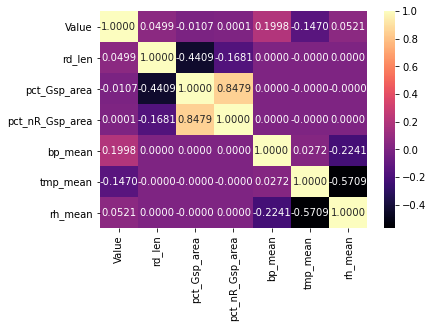

In [44]:
# check correlation between PM data and the conditional variables
sns.heatmap(df.merge(cond,how='left',on='DateTime').corr(),cmap='magma',annot=True,
            fmt='0.4f')

In [47]:
df['Site'].unique().shape

(21,)

In [50]:
# prepare variables for the OLS model
Y=df['Value'].values
X=np.tile(cond[['bp_mean','tmp_mean','rh_mean']].values,(21,1))
print(X.shape,Y.shape)

(183960, 3) (183960,)


In [51]:
# fit a OLS model
m_multi=sm.OLS(Y,X)
m_multi_fit=m_multi.fit()
m_multi_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.569
Model:                            OLS   Adj. R-squared (uncentered):              0.569
Method:                 Least Squares   F-statistic:                          8.103e+04
Date:                Tue, 08 Mar 2022   Prob (F-statistic):                        0.00
Time:                        15:15:45   Log-Likelihood:                     -6.9042e+05
No. Observations:              183960   AIC:                                  1.381e+06
Df Residuals:                  183957   BIC:                                  1.381e+06
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0187      0.000    103.250      0.000       0.018       0.019
x2            -0.3361      0.005    -67.010      0.000      -0.346      -0.326
x3            -0.0385      0.002    -21.582      0.000      -0.042      -0.035
==============================================================================
Omnibus:                   234870.942   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        346510017.774
Skew:                           6.280   Prob(JB):                         0.00
Kurtosis:                     215.248   Cond. No.                         215.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# kernel weight matrix for the sites
weight=Kernel.from_dataframe(loc_gdf,geom_col='geometry',function='gaussian')

In [53]:
# covert the DateTime column to numpy.datetime variable
df['DateTime']=pd.to_datetime(df['DateTime'])

In [54]:
# moran's Is for PM readings on different days
moran=[]
for date in df['DateTime'].unique():
    mi=Moran(df[df['DateTime']==date].Value.values,weight)
    moran.append(mi.I)
len(moran)

8760

<AxesSubplot:>

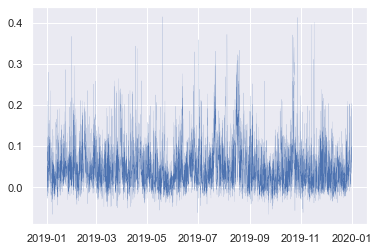

In [65]:
# change of moran's I during the year of 2019
sns.set_theme(style='darkgrid')
sns.lineplot(x=df['DateTime'].unique(),y=moran,linewidth=0.1)

In [56]:
# global moran's I for pct of gsp
moran_gsp=Moran(loc_gdf['pct_Gsp_area'].values,weight)
round(moran_gsp.I,5)

0.15159

In [57]:
# global moran's I for pct of near-road gsp
moran_nR=Moran(loc_gdf['pct_nR_Gsp_area'].values,weight)
round(moran_nR.I,5)

0.08686

In [58]:
# merge with conditional variables
cond['DateTime']=pd.to_datetime(cond['DateTime'])
df=df.merge(cond,on='DateTime')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Site             183960 non-null  object        
 1   Value            183960 non-null  float64       
 2   DateTime         183960 non-null  datetime64[ns]
 3   geometry         183960 non-null  geometry      
 4   rd_len           183960 non-null  float64       
 5   pct_Gsp_area     183960 non-null  float64       
 6   pct_nR_Gsp_area  183960 non-null  float64       
 7   bp_mean          183960 non-null  float64       
 8   tmp_mean         183960 non-null  float64       
 9   rh_mean          183960 non-null  float64       
dtypes: datetime64[ns](1), float64(7), geometry(1), object(1)
memory usage: 15.4+ MB


In [59]:
# set up a new column for month information
df['month']=df['DateTime'].dt.month

<AxesSubplot:xlabel='month'>

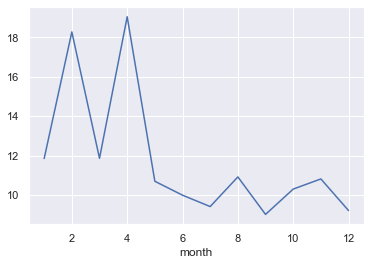

In [60]:
# plot monthly mean
df.groupby('month').mean()['Value'].plot()

In [61]:
# identify high period and low period
high=df[df['month'].isin([1,2,3,4])].copy()
low=df[~df['month'].isin([1,2,3,4])].copy()

In [62]:
print('high: '+str(high.shape)+'\nlow: '+str(low.shape))

high: (60480, 11)
low: (123480, 11)


In [71]:
vars=['pct_Gsp_area','pct_nR_Gsp_area','bp_mean','tmp_mean','rh_mean']

Y=high['Value'].values
X=high[vars].values

m_high=OLS(Y,X)
print(m_high.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:       60480
Mean dependent var  :     15.1481                Number of Variables   :           6
S.D. dependent var  :     13.1975                Degrees of Freedom    :       60474
R-squared           :      0.0618
Adjusted R-squared  :      0.0617
Sum squared residual: 9883325.791                F-statistic           :    796.1438
Sigma-square        :     163.431                Prob(F-statistic)     :           0
S.E. of regression  :      12.784                Log likelihood        : -239929.261
Sigma-square ML     :     163.415                Akaike info criterion :  479870.522
S.E of regression ML:     12.7834                Schwarz criterion     :  479924.583

-----------------------------------------------------------------------------

In [72]:
from sklearn.linear_model import LinearRegression

reg=LinearRegression().fit(X,Y)
reg.score(X,Y)

0.0617599314960704

<AxesSubplot:xlabel='DateTime'>

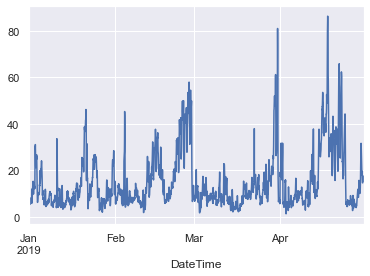

In [66]:
high.groupby('DateTime').mean()['Value'].plot()

In [67]:
df['week']=df['DateTime'].dt.isocalendar().week

In [68]:
weekly=df.groupby(['Site','week']).mean().reset_index()
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Site             1092 non-null   object 
 1   week             1092 non-null   int64  
 2   Value            1092 non-null   float64
 3   rd_len           1092 non-null   float64
 4   pct_Gsp_area     1092 non-null   float64
 5   pct_nR_Gsp_area  1092 non-null   float64
 6   bp_mean          1092 non-null   float64
 7   tmp_mean         1092 non-null   float64
 8   rh_mean          1092 non-null   float64
 9   month            1092 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 85.4+ KB


In [69]:
weekly.drop('month',axis=1,inplace=True)

In [73]:
weekly[['Value']+vars].corr().round(4)

,Value,pct_Gsp_area,pct_nR_Gsp_area,bp_mean,tmp_mean,rh_mean
Value,1.0000,-0.0203,0.0001,0.3915,-0.2028,-0.2888
pct_Gsp_area,-0.0203,1.0000,0.8479,0.0000,0.0000,0.0000
pct_nR_Gsp_area,0.0001,0.8479,1.0000,0.0000,0.0000,0.0000
bp_mean,0.3915,0.0000,0.0000,1.0000,0.0868,-0.4388
tmp_mean,-0.2028,0.0000,0.0000,0.0868,1.0000,-0.5006
rh_mean,-0.2888,0.0000,0.0000,-0.4388,-0.5006,1.0000


In [74]:
Y=weekly['Value'].values
Y=Y/np.linalg.norm(Y,axis=0)

X=weekly[vars].values

m_weekly=OLS(Y,X,name_y='PM reading',name_x=vars)

print(m_weekly.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  PM reading                Number of Observations:        1092
Mean dependent var  :      0.0273                Number of Variables   :           6
S.D. dependent var  :      0.0130                Degrees of Freedom    :        1086
R-squared           :      0.2986
Adjusted R-squared  :      0.2954
Sum squared residual:       0.129                F-statistic           :     92.4676
Sigma-square        :       0.000                Prob(F-statistic)     :   3.581e-81
S.E. of regression  :       0.011                Log likelihood        :    3389.162
Sigma-square ML     :       0.000                Akaike info criterion :   -6766.325
S.E of regression ML:      0.0109                Schwarz criterion     :   -6736.350

-----------------------------------------------------------------------------

<AxesSubplot:xlabel='DateTime'>

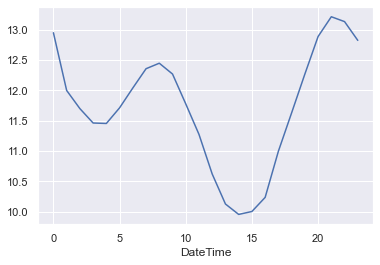

In [76]:
df.groupby(df['DateTime'].dt.hour).mean()['Value'].plot()

<AxesSubplot:xlabel='DateTime'>

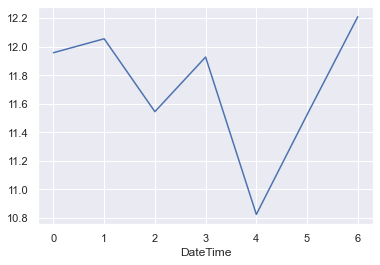

In [77]:
df.groupby(df['DateTime'].dt.dayofweek).mean()['Value'].plot()

<AxesSubplot:xlabel='DateTime'>

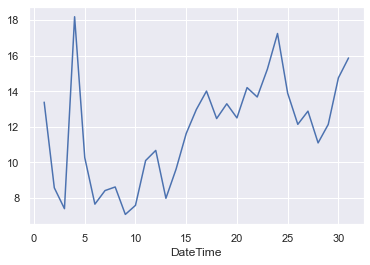

In [78]:
df.groupby(df['DateTime'].dt.day).mean()['Value'].plot()

In [86]:
time_df=df.set_index('DateTime')

In [95]:
time_df.loc[time_df.index[0],'Value']

DateTime
2019-01-01    13.0
2019-01-01    17.0
2019-01-01    36.0
2019-01-01    21.4
2019-01-01    16.1
2019-01-01    29.1
2019-01-01    23.3
2019-01-01    53.3
2019-01-01    43.1
2019-01-01    14.7
2019-01-01    15.8
2019-01-01    11.2
2019-01-01    14.0
2019-01-01    26.3
2019-01-01    22.0
2019-01-01    35.1
2019-01-01    20.4
2019-01-01    20.5
2019-01-01    11.0
2019-01-01    18.2
2019-01-01    35.5
Name: Value, dtype: float64

In [81]:
for time in time_df.index.values:
    y=df[df['DateTime']==time]

numpy.datetime64